"""
Created on Tue April  9 11:38:07 2024

@author: WilhemHector

Wake loss simulation, farm layout optimization and cost estimation

Assumptions:
    The wind farm center points are 2.25 miles from the the island and are spaced by 24 degrees
    No blockage effect considered. We are using Squared Sum Superposition for the wake models
    Any wake model considered uses the default parameters with which it was validated
"""

<xarray.DataArray (sector: 12, ws: 5)> Size: 480B
array([[2.91689583e-02, 2.21505150e-02, 4.80214504e-03, 4.73314816e-04,
        2.45962897e-05],
       [2.69422412e-02, 2.05126578e-02, 3.38013779e-03, 1.93156550e-04,
        4.50312116e-06],
       [2.54965689e-02, 1.83033290e-02, 3.76226668e-03, 3.53962195e-04,
        1.77917005e-05],
       [1.77522668e-02, 1.84751291e-02, 4.07652516e-03, 2.83356564e-04,
        6.75353965e-06],
       [1.13179230e-02, 1.79493683e-02, 6.37634205e-03, 7.44239227e-04,
        3.09524018e-05],
       [1.09708617e-02, 1.52217063e-02, 6.83226823e-03, 1.56993359e-03,
        2.14959410e-04],
       [1.65374766e-02, 3.42694321e-02, 2.69716559e-02, 1.22487730e-02,
        3.51514179e-03],
       [2.59183053e-02, 6.27004251e-02, 5.68525644e-02, 2.94163037e-02,
        9.47560975e-03],
       [2.82792458e-02, 5.55949523e-02, 3.65443995e-02, 1.23492738e-02,
        2.37918003e-03],
       [3.89921736e-02, 4.73804942e-02, 1.65759839e-02, 2.60541938e-03,
        2.07203815e-04],
       [4.97057528e-02, 4.89434257e-02, 1.21162685e-02, 1.17616917e-03,
        5.06480159e-05],
       [4.40282131e-02, 4.39677965e-02, 9.71809265e-03, 7.26229100e-04,
        2.05187956e-05]])
Coordinates:
  * ws       (ws) float64 40B 2.5 7.5 12.5 17.5 22.5
  * sector   (sector) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

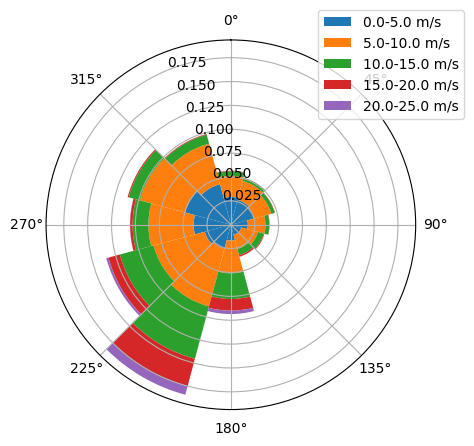

In [ ]:
import numpy as np
import pandas as pd
from Hull_Site import HullSite45, VWT3
from py_wake.deficit_models.gaussian import BastankhahGaussian,BastankhahGaussianDeficit
from py_wake.superposition_models import SquaredSum
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.turbulence_models import CrespoHernandez, STF2017TurbulenceModel
import os
from py_wake.utils.plotting import setup_plot
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from py_wake.flow_map import HorizontalGrid
from py_wake.flow_map import XYGrid
from py_wake import XZGrid
from py_wake.examples.data import example_data_path
import utm

from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.plotting import NoPlot, XYPlotComp
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import CircleBoundaryConstraint, XYBoundaryConstraint
from topfarm.constraint_components.constraint_aggregation import ConstraintAggregation
from topfarm.constraint_components.constraint_aggregation import DistanceConstraintAggregation

# Plot wind rose
plt.figure()
site = HullSite45(42.20889, 124.7488486)
site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25])

In [2]:
# Optimization around the island

n_wts = 45 # Number of turbines in the farm

def hull_constraints(diam, boundary, n_wt=n_wts):
    """Constraints for Hull Mass wind farms

    n_wt : int, optional. Number of wind turbines in farm (default is 4)
    boundary: list of tuples representing vertices position

    Returns constr : list of topfarm constraints
        Spacing constraint and boundary constraint for Hull farms
    """
    spac_constr = SpacingConstraint(3 * diam) # Minimum constraints
    bound_constr = XYBoundaryConstraint(boundary, 'convex_hull')
    return [spac_constr, bound_constr]

def bound_vertices(c_lat, c_lon):
    return np.array([*zip(c_lat, c_lon)])

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


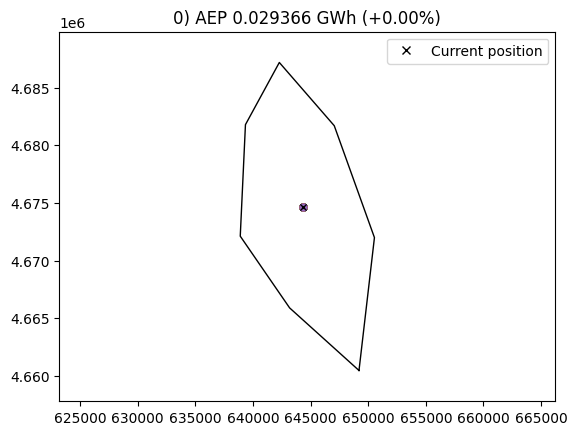

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0515670315816663
            Iterations: 22
            Function evaluations: 33
            Gradient evaluations: 22
Optimization Complete
-----------------------------------


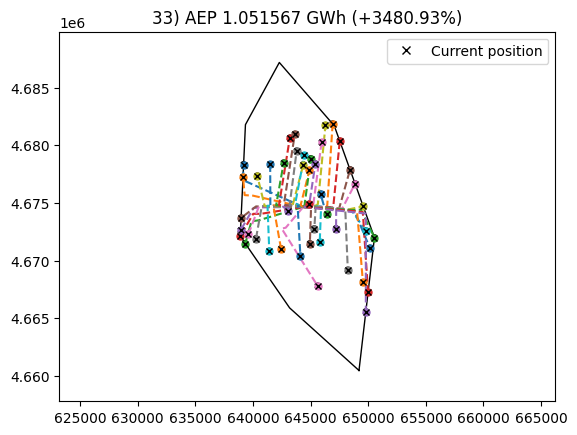

In [8]:
site45 = HullSite45(42.20889, 124.7488486)
wind_turbine45 = VWT3()
wfm = PropagateDownwind(site45, wind_turbine45, wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=False),
                                        superpositionModel=SquaredSum(), deflectionModel=None) # Wind farm model

wt_x,wt_y , zone_number, zone_letter= site45.initial_coordinates()

import numpy as np
import utm

# Original coordinates (latitude and longitude)
latitudes = np.array([42.33667, 42.28333, 42.28083, 42.18306, 42.18667, 42.12361, 42.06806])
longitudes = np.array([124.72694, 124.69, 124.78333, 124.82306, 124.68222, 124.7325 , 124.80389])

# Compute the center latitude
center_lat = np.mean(latitudes)

# Scale factor for reducing vertical extent (e.g., 90% of the original range)
scale_factor = 0.9

# Adjust latitudes closer to the center
adjusted_latitudes = center_lat + (latitudes - center_lat) * scale_factor

# Convert to UTM coordinates
corner_x, corner_y, _, _ = utm.from_latlon(adjusted_latitudes, longitudes, zone_number, zone_letter)


objective = PyWakeAEPCostModelComponent(wfm, n_wts) # Wrapper for the objective function (AEP including wakes)

tf = TopFarmProblem(
        design_vars= {'x':wt_x, 'y': wt_y},
        driver=EasyScipyOptimizeDriver(),
        cost_comp= objective,
        constraints= hull_constraints(167,bound_vertices(corner_x, corner_y)),
        plot_comp=XYPlotComp(plot_initial=False),
        ) # TopFarm problem definition

cost, op_state, _= tf.optimize()

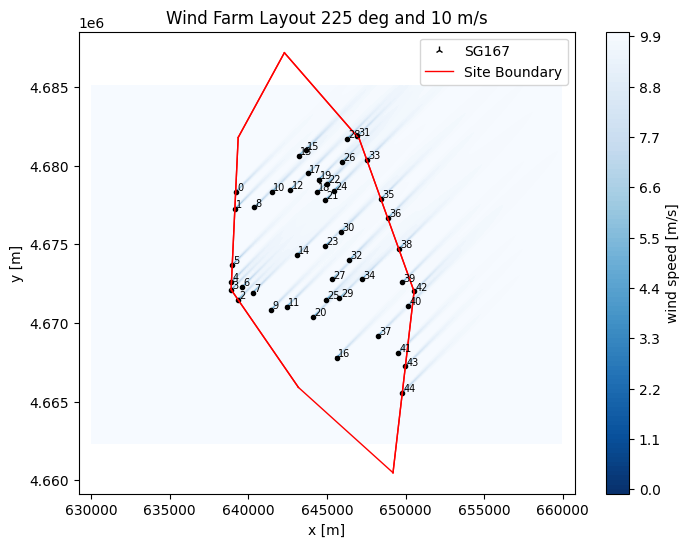

In [ ]:
# Layout optimization visualization
from scipy.spatial import ConvexHull
# sim_res = wfm(wt_x, wt_y) # intial simulation result
wt_x_op, wt_y_op = op_state['x'], op_state['y'] # Optimized layout
sim_res_op = wfm(wt_x_op, wt_y_op) # Simulate result for optimize turbine placement

wdir = 225 # Wind direction to plot flow map
wsp = 10 # Wind speed to plot flow map

ymin = min(wt_y)-3000
ymax = max(wt_y)+3000
plt.figure(figsize=(8,6))
flow_map = sim_res_op.flow_map(HorizontalGrid(x = np.arange(630000,660000,100),),
                            wd=wdir,
                            ws = wsp).plot_wake_map()
# Combine x and y into an array of (x, y) points
points = np.column_stack((corner_x, corner_y))
hull = ConvexHull(points)

# Plot the convex hull by connecting the vertices in order
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-', linewidth=1)

# Close the loop by adding the first point to the end of the hull vertices
plt.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'r-', linewidth=1, label='Site Boundary')

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wind Farm Layout'+ f' {wdir} deg and {wsp} m/s')
plt.xlim(635000,655000)
plt.legend()

In [5]:
# Wake Loss and Capacity factor of optimized farm
aep_with_wake_loss = sim_res_op.aep().sum().data
aep_witout_wake_loss = sim_res_op.aep(with_wake_loss=False).sum().data
print('total wake loss:',((aep_witout_wake_loss-aep_with_wake_loss) / aep_witout_wake_loss)*100, '%')
print('Capacity factor:', (aep_with_wake_loss/105.12)*100, '%')

total wake loss: 4.392897891471862 %
Capacity factor: 1.0113783010631576 %


In [6]:
sim_res_op.aep().sum().data

array(1.06316087)

In [7]:
# Map of the turbine placements
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# Coordinates for wind farms are the same as valid_coord above

# Create a GeoDataFrame for the wind farms
geometry = [Point(lon, lat) for lat, lon in valid_coord]
wind_farms = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326")

# Create a base map
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot wind farms
wind_farms.plot(ax=ax, marker='x', color='red', markersize=100, label='Wind Farm')

# Highlight the "Optimum Location"
optimum_location = wind_farms.iloc[[4]]  # The 5th coordinate
optimum_location.plot(ax=ax, marker='x', color='green', markersize=200, edgecolor='black', label='Optimum Location')

# Removing the scale bar and text
# scale_length = 0.005  # Approx 500m in longitude difference
# scale_line_x = [valid_coord[4][1] - scale_length, valid_coord[4][1] + scale_length]
# scale_line_y = [valid_coord[4][0], valid_coord[4][0]]
# plt.plot(scale_line_x, scale_line_y, 'k-', lw=3)
# plt.text(sum(scale_line_x) / 2, valid_coord[6][0] - 0.002, '500m', horizontalalignment='center')

# Adding the legend
ax.legend(loc='upper right')

# Setting the boundary for the map
minx, miny, maxx, maxy = wind_farms.total_bounds
ax.set_xlim(minx - 0.02, maxx + 0.02)
ax.set_ylim(miny - 0.02, maxy + 0.02)
plt.gca().set_aspect('equal', adjustable='box')

# Adding a square boundary using simple plot lines
plt.plot([minx - 0.02, maxx + 0.02], [miny - 0.02, miny - 0.02], color='black', linewidth=2)
plt.plot([minx - 0.02, maxx + 0.02], [maxy + 0.02, maxy + 0.02], color='black', linewidth=2)
plt.plot([minx - 0.02, minx - 0.02], [miny - 0.02, maxy + 0.02], color='black', linewidth=2)
plt.plot([maxx + 0.02, maxx + 0.02], [miny - 0.02, maxy + 0.02], color='black', linewidth=2)

# Adding a basemap
ctx.add_basemap(ax, crs=wind_farms.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Title and labels
plt.title("Wind Farms Siting Trials")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Save the plot to a file
# plt.savefig('wind_farms_siting_trials.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

NameError: name 'valid_coord' is not defined

In [ ]:
# Cost analysis
from topfarm.cost_models.economic_models.turbine_cost import economic_evaluation as ee_2

# vectors for turbine properties: diameter, rated power and hub height. these are inputs to the cost model
Drotor_vector = [wind_turbine45.diameter()] * n_wts
power_rated_vector = [float(wind_turbine45.power(20))*1e-3] * n_wts
hub_height_vector = [wind_turbine45.hub_height()] * n_wts

# Additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 3.21869    # [km]
energy_price = 0.1               # [Euro/kWh] What we get per kWh
project_duration = 20            # [years]
rated_rpm_array = [16.1] * n_wts    # [rpm]
water_depth_array = [12] * n_wts  # [m]

aep_vector = np.array([sim_res_op.Power.sel(wt=0).sum().values/1e6,
                       sim_res_op.Power.sel(wt=1).sum().values/1e6,
                       sim_res_op.Power.sel(wt=2).sum().values/1e6,
                       sim_res_op.Power.sel(wt=3).sum().values/1e6])


# set up function for new cost model with initial inputs as set above
eco_eval = ee_2(Drotor_vector, power_rated_vector, hub_height_vector, aep_vector)
eco_eval.calculate_irr()
eco_eval.cost

print('Wind turbine configuration costs', eco_eval.cost)
print('IRR', eco_eval.IRR)

# just the cost bar lot
barplotvector = np.asarray([eco_eval.blade_B_costs[0], eco_eval.hub_cost[0], eco_eval.pitch_system_cost[0], eco_eval.nose_cone_cost[0],
                                eco_eval.bearing_cost[0], eco_eval.brake_and_coupling_cost[0], eco_eval.generator_cost[0],
                                eco_eval.variablespeed_electronics[0], eco_eval.yaw_system_cost[0], eco_eval.mainframe_cost[0],
                                eco_eval.platform_railing_cost[0], eco_eval.electrical_connection_cost[0],
                                eco_eval.hydraulic_cooling_system_cost[0], eco_eval.nacelle_cost[0], 35000,
                                eco_eval.tower_cost[0], eco_eval.foundation_cost[0], eco_eval.trasport_cost[0], eco_eval.roads_civil_cost_cost[0],
                                eco_eval.assembly_and_installation_cost[0], eco_eval.electrical_interface_cost[0]] / eco_eval.cost[0])
N = 21
ind = np.arange(N)  # the x locations for the groups
width = 0.5       # the width of the bars

plt.rcParams.update({'figure.autolayout': True})
fig, ax = plt.subplots()
ax.barh(ind, barplotvector, width, color='b')

# add some text for labels, title and axes ticks
ax.set_xlabel('Procentage of total costs [%]')
ax.set_title('Wind Turbine components costs')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(('Blades', 'Hub', 'Pitch System', 'Nose cone', 'Bearing', 'Break and coupling', 'Generator',
                    'Variable speed electornics', 'Yaw system', 'Mainframe', 'Platform railing', 'Electical connections',
                    'Hydraulic cooling systems', 'Nacelle cover', 'Control', 'Tower', 'Foundation', 'Transportation',
                    'Roads', 'Assembly and installation', 'Electrical interface'))
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()


In [ ]:
# Farm AEP database
farms_database

In [ ]:
# Time series wind data
frame_8760 = pd.read_excel('8760.xlsx')
dir_120 = np.array(frame_8760['Dir_120'])
ws_120 = np.array(frame_8760['Spd_120'])
ti_120 = np.array(frame_8760['TI_120'])

time_stamp = np.arange(len(dir_120))/7.5/24

# Optimum wind farm simulation with 8760 data and 8 minute
sim_res_time = wfm(wt_x_op, wt_y_op, # wind turbine positions
                            wd=dir_120, # Wind direction time series
                            ws=ws_120, # Wind speed time series
                            time=time_stamp, # time stamps
                      )

hourly_output = np.empty(0) # Hourly power output from the farm
for ix in range(len(ws_120)):
    hourly_output = np.append(hourly_output,sim_res.Power.sel(wt=0, wd=dir_120[ix], ws= ws_120[ix], method='nearest').data/1e6*4 )

d = np.load(example_data_path + "/time_series.npz")
n_days=366
# plot time series
axes = plt.subplots(3,1, sharex=True, figsize=(16,10))[1]

for ax, (v,l) in zip(axes, [(dir_120, 'Wind direction [deg]'),(ws_120,'Wind speed [m/s]'),(hourly_output,'Hourly Output (MW)')]):
    ax.plot(time_stamp, v)
    ax.set_ylabel(l, fontsize= 18)
_ = ax.set_xlabel('Time [day]', fontsize= 18)

In [ ]:

aep_with_wake_loss_time = sim_res_time.aep().sum().data
aep_witout_wake_loss_time = sim_res_time.aep(with_wake_loss=False).sum().data

print('total wake loss:',((aep_witout_wake_loss_time-aep_with_wake_loss_time) / aep_witout_wake_loss_time)*100, '%')
print('Capacity factor:', (aep_with_wake_loss_time/105.12)*100, '%')
aep_with_wake_loss_time


In [ ]:
# import pandas as pd

# # Create a DataFrame from the array
# df = pd.DataFrame(hourly_output)
# # Save as an Excel file
# df.to_excel('hourlyoutput_data.xlsx', index=False, header=False)